## YOLO run on a video
- To be used in Argus2 visual prosthesis system -> 6x10 electrodes/phosphenes grid 
#### Detector class

In [11]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from operator import itemgetter


encoding = {
    "bottle": np.array([0,0,0,0,1,1,0,0,0,0, 0,0,0,0,1,1,0,0,0,0, 0,0,0,1,1,1,1,0,0,0, 0,0,0,1,1,1,1,0,0,0, 0,0,0,1,1,1,1,0,0,0, 0,0,0,1,1,1,1,0,0,0]).reshape((6,10)),
    "cup": np.array([0,1,1,0,0,0,1,1,0,0, 0,1,1,0,0,0,1,1,1,1, 0,1,1,0,0,0,1,1,1,1, 0,1,1,0,0,0,1,1,1,1, 0,1,1,1,1,1,1,1,0,0, 0,1,1,1,1,1,1,1,0,0]).reshape((6,10)),
    "laptop": np.array([0,1,1,1,1,1,1,1,1,0, 0,1,0,0,0,0,0,0,1,0, 0,1,0,0,0,0,0,0,1,0, 0,1,0,0,0,0,0,0,1,0, 0,1,1,1,1,1,1,1,1,0, 0,1,1,1,1,1,1,1,1,0]).reshape((6,10)),
    "fork":np.array([1,1,0,0,1,1,0,0,1,1, 1,1,0,0,1,1,0,0,1,1, 1,1,1,1,1,1,1,1,1,1, 1,1,1,1,1,1,1,1,1,1, 0,0,0,0,1,1,0,0,0,0, 0,0,0,0,1,1,0,0,0,0]).reshape((6,10))
}


class yoloDetector():
    
    def __init__(self,img,weights="\yolov4.weights",cfgnet="\yolov4.cfg",scale =0.00392,fps = 15.0):
        
        self.Width  = img.shape[1]
        self.Height = img.shape[0]   
        self.classpath = os.getcwd()[:-7]+ "cfg\coco.names"
        self.cfgpath = os.getcwd()[:-7]+ "cfg"
        self.weightspath = self.cfgpath + weights
        self.confignet = self.cfgpath+cfgnet 
        self.scale = scale
        self.classes = None        
        self.same = 0
        self.fps = fps
        self.oldCens = []
        self.blinkIx = 0
        
        with open(self.classpath, 'r') as f:
            self.classes = [line.strip() for line in f.readlines()]

        self.COLORS = np.random.uniform(0, 255, size=(len(self.classes), 3))

        # read pre-trained model and config file
        self.net = cv2.dnn.readNet(self.weightspath, self.confignet)


        #this fixes the input size
        blob = cv2.dnn.blobFromImage(img, self.scale, (416,416), (0,0,0), True, crop=False)
        self.net.setInput(blob)
        
        self.output_layers = self.get_output_layers(self.net)
        
        
    def get_output_layers(self,net):

        layer_names = net.getLayerNames()

        x = net.getUnconnectedOutLayers()
        output_layers = [layer_names[i- 1] for i in net.getUnconnectedOutLayers()]

        return output_layers

    # function to draw bounding box on the detected object with class name
    def draw_bounding_box(self,img, class_id, confidence, x, y, x_plus_w, y_plus_h):

        label = str(self.classes[class_id])

        color = self.COLORS[class_id]

        cv2.rectangle(img, (x,y), (x_plus_w,y_plus_h), color, 2)

        cv2.putText(img, label, (x-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        return img
    
    def encode(self,img,classname,gridx,gridy):
        
        global encoding
        #encode
        wherey,wherex = np.nonzero(encoding[classname]) 
        
        for i in range(len(wherex)):
            cv2.circle(img,(gridx[wherex[i]],gridy[wherey[i]]),radius=round((gridx[1]-gridx[0])/2),color=[255,255,255],thickness=-1)
        
        img = cv2.GaussianBlur(img ,(23,23),0)
        
        return img
    
    
    
    def isSame(self,img,newCens): #newCens -> (x,y,class)
        """
        criteria: 
        -if same # of objs. (possibly problematic with tiny-yolo, not so stable)
        -if boxes centers in +- 10% of where they were before -> tolerance
        """
        if not len(self.oldCens) == 0 and (len(newCens) == len(self.oldCens)) : #n elems
            #position. True if distance < tolerance* ImgSize
            criteria = [np.linalg.norm(x) < (0.1* self.Width if self.Width < self.Height else self.Height) for x in np.int64(np.array(self.oldCens)[:,0:2])-np.int64(np.array(newCens)[:,0:2])]
            return all(criteria)
        else: 
            return False
        

    
    def infer(self,img):
        
        blob = cv2.dnn.blobFromImage(img, self.scale, (416,416), (0,0,0), True, crop=False)
        self.net.setInput(blob)
        outs = self.net.forward(self.output_layers)

        # initialization
        class_ids = []
        confidences = []
        boxes = []
        conf_threshold = 0.5
        nms_threshold = 0.4

        # for each detetion from each output layer 
        # get the confidence, class id, bounding box params
        # and ignore weak detections (confidence < 0.5)
        for out in outs:                       #one out is a dimxdimx(255= B*(classes+5=attributes of boundbox))
            for detection in out:              #3 outputs per image, each out 3 bounding boxes
                scores = detection[5:]         #scores of the classes
                class_id = np.argmax(scores)   #most likely class
                confidence = scores[class_id]  #likelyhood 
                if confidence > 0.5:
                    center_x = int(detection[0] * self.Width)
                    center_y = int(detection[1] * self.Height) 
                    w = int(detection[2] * self.Width)
                    h = int(detection[3] * self.Height)
                    x = center_x - w / 2
                    y = center_y - h / 2
                    class_ids.append(class_id)
                    confidences.append(float(confidence))
                    boxes.append([x, y, w, h])
        
        # non-max suppression
        indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

        # go through the detections remaining
        # after nms and draw bounding box
        detectImg = img
        
        #for showcase -> have to divide it into 6x10 -> if center of obj in one grid -> illuminate
        #add circle at center of grid-box and then gaussian blur 4each obj. if multiple objs, more illuminated
        phosphImg = np.copy(img)
        
        #black
        phosphImg[:,:,:] = 0
        
        gridcounter = np.zeros((6,10))
        
        #conventional plt notation for cartesian axes (y reversed)
        gridx = np.round(np.linspace(0,self.Width,11)) #10
        gridy = np.round(np.linspace(0,self.Height,7)) #6
        
        #optional -> display grid
        for i in range(len(gridx)):
            cv2.line(detectImg,(round(gridx[i]),0),(round(gridx[i]),self.Height),[0,255,0],thickness=1)
            cv2.line(phosphImg,(round(gridx[i]),0),(round(gridx[i]),self.Height),[0,255,0],thickness=1)
        for i in range(len(gridy)):
            cv2.line(detectImg,(0,round(gridy[i])),(self.Width,round(gridy[i])),[0,255,0],thickness=1)
            cv2.line(phosphImg,(0,round(gridy[i])),(self.Width,round(gridy[i])),[0,255,0],thickness=1)
        
        
        centers = []
        
        for i in indices:
            i = i
            box = boxes[i]
            x = box[0]
            y = box[1]
            w = box[2]
            h = box[3]
            detectImg = self.draw_bounding_box(detectImg, class_ids[i], confidences[i], round(x), round(y), round(x+w), round(y+h))
            
            #central pixel
            cenx = round(x + w/2)
            ceny = round(y +h/2)

            centers.append(((gridx<cenx).sum()-1,(gridy<ceny).sum()-1,self.classes[class_ids[i]]))
            
            #show detected center
            cv2.circle(detectImg,(cenx,ceny),radius=round(5),color=[255,255,255],thickness=-1)
            
            #check to which grid-cell the center of the bounding box belongs.
            gridcounter[(gridy<ceny).sum()-1,(gridx<cenx).sum()-1] = gridcounter[(gridy<ceny).sum()-1,(gridx<cenx).sum()-1] + 1
        
        #sorted in increasing dim1 = y -> correspond to dim0 below
        centers =sorted(centers, key=itemgetter(1))
        
        #increase counter. if not same, reset all
        (self.same,self.blinkIx) = (self.same+1,self.blinkIx) if self.isSame(img,newCens=centers) else (0,0)
        self.oldCens = centers
        
        """
        Draw phosphenes
        """
        
        #gridx is now center pixel of each gridcell -> where to draw
        gridx = [round((gridx[i]+gridx[i+1])/2) for i in range(len(gridx)) if i < len(gridx)-1] #along dimension1
        gridy = [round((gridy[i]+gridy[i+1])/2) for i in range(len(gridy)) if i < len(gridy)-1] #dim0
        
        #dim0 = y -> nonzero scans the matrix row by row (increasing y) ->the order is increasing y
        wherey,wherex = np.nonzero(gridcounter) #eg: y = [0 0 0 1 1 2]    if gridcount= [1 0 1 1,
                                                    # x= [0 2 3 0 2 0] -> 6 elems!=0 ->  1 0 0 1, 
                                                                                      #  1 0 0 0]
        #ksize needs to be odd
        ksize = [round((gridx[1]-gridx[0])/4),round((gridy[1]-gridy[0])/4)]
        ksize[0] = ksize[0]-1 if ksize[0]%2 == 0 else ksize[0]
        ksize[1] = ksize[1]-1 if ksize[1]%2 == 0 else ksize[1]
        
        #more obj in one gridbox -> more ligth. if no obj, skip
        for i in range(len(wherex)): 
            
            #if N obj in one grid-cell > 1 -> more ligth
            for j in range(round(gridcounter[wherey[i],wherex[i]])):

                #if isSame for >3s  -> blink obj for 3 seconds and then encode for 3 secs
                if self.same > self.fps*3 and self.same < self.fps*3*2 and i == self.blinkIx and self.same%2: #if blink period,and blink objs
                    #light-off. skip one every two frames -> if 15 fps -> blink Hz = circa 7.5Hz l
                    continue                  
                
                elif self.same > self.fps*3*2 and self.same < self.fps*3*3: #encode -> only display encoding  
                    #2nd arg is classname. 
                    phosphImg = self.encode(phosphImg,self.oldCens[self.blinkIx][2],gridx,gridy) 
                    return detectImg,phosphImg
                
                elif self.same > self.fps*3*3: #if finished encoding, reset for next item
                    self.same = self.fps*3+1
                    self.blinkIx = self.blinkIx+1 if self.blinkIx < len(self.oldCens) else 0#if there are items left, increase, otherwise reset
                    
                #draw and smooth. radius == .33 of distance center-border == .33 distance border-border
                cv2.circle(phosphImg,(gridx[wherex[i]],gridy[wherey[i]]),radius=round((gridx[1]-gridx[0])/3),color=[255,255,255],thickness=-1) 
                
                #blur. row == 1st index == y. -> center +- .5 distance
                upY = round(gridy[wherey[i]]-(gridy[1]-gridy[0])/2) 
                lowY = round(gridy[wherey[i]]+(gridy[1]-gridy[0])/2)
                lowX = round(gridx[wherex[i]]-(gridx[1]-gridx[0])/2) 
                upX = round(gridx[wherex[i]]+(gridx[1]-gridx[0])/2)
                
                phosphImg[upY:lowY,lowX:upX] =  cv2.GaussianBlur(phosphImg[upY:lowY,lowX:upX] ,ksize,0)
        
        return detectImg,phosphImg
        

#### One-Frame showcase
- display the center of the detected bounding boxes in the corresponding grid-cells
- Img on the rx displays the representation on the 6x10 grid -> what the patient would see

out dim0 is:  576  dim1 is:  768


(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x1dfead49888>)

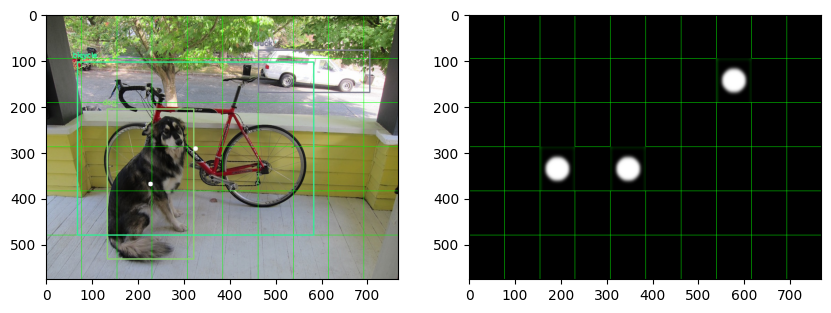

In [14]:
import cv2
from matplotlib import pyplot as plt
from matplotlib import figure
imgpath = r"C:\Users\Ale\PYEnv\env\JupyterLab\BionicSensesYolo\data\dog.jpg"
img = cv2.imread(imgpath)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

print("out dim0 is: ",img.shape[0]," dim1 is: ",img.shape[1]) 

detector = yoloDetector(img,weights="\yolov4-tiny.weights",cfgnet="\yolov4-tiny.cfg")
img,phosph = detector.infer(img)
fig = plt.figure(figsize=(10,8))
plt.subplot(121),plt.imshow(img)
plt.subplot(122),plt.imshow(phosph)


#### Test on Video input

- yolov4 much slower but much more stable than yolov4-tiny in my tests
- input video about 30 fps -> output about 15 fps (due to hw constraints, speed the process without lowering too much fps)

In [12]:
import time

datapath = os.getcwd()[:-7]+"data"

videopath = datapath + '\Bottle.mp4'
outpath = datapath + "\outVideo.avi"
outpath2 = datapath +"\phosphVideo.avi"
outpath3 = datapath +"\combinedVideo.avi"
fpsOut = 15

print("datapath is: ",datapath)

try:
    
    #reader
    cap = cv2.VideoCapture(videopath)
    
    fps = cap.get(cv2.CAP_PROP_FPS)      # OpenCV v2.x used "CV_CAP_PROP_FPS"
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = frame_count/fps
    print('fps = ' + str(fps))
    print('number of frames = ' + str(frame_count))
    print('duration (S) = ' + str(duration))
 
    init_ret,init_frame = cap.read()
    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'XVID')  #*'MP4V' #'M','J','P','G'
    
    detector = yoloDetector(init_frame,weights="\yolov4.weights",cfgnet="\yolov4.cfg")
    print("video frame size = ",detector.Width," ",detector.Height)
    print("init frame shape: ",init_frame.shape)
    
    starttime = time.time()
    
    #specified dimension has to match with input !
    out = cv2.VideoWriter(outpath, fourcc, 15.0, (init_frame.shape[1],init_frame.shape[0]))
    out2 = cv2.VideoWriter(outpath2,fourcc,15.0, (init_frame.shape[1],init_frame.shape[0]))
    out3 = cv2.VideoWriter(outpath3,fourcc,15.0, (init_frame.shape[1]*2,init_frame.shape[0]))

    skip = True
    while cap.isOpened():

        ret, frame = cap.read()
        # if frame is read correctly ret is True
        if not ret:
            print("Can't receive frame (stream end?). Exiting ...")
            break
        
        #skip 50% of frames -> video 
        skip = not skip
        if skip:
            continue
            
        frame,phosphFrame = detector.infer(frame)     
        combFrame = np.concatenate([frame,phosphFrame],axis=1)
        
        out.write(frame)
        out2.write(phosphFrame)
        out3.write(combFrame)
        

        #exit loop
        if cv2.waitKey(1) == ord('q'):    
            break

finally:
    
    print("elapsed: ",time.time()-starttime) 
    cap.release()                            
    out.release()
    out2.release()
    out3.release()
    cv2.destroyAllWindows()

datapath is:  C:\Users\Ale\PYEnv\env\JupyterLab\BionicSensesYolo\data
fps = 30.01938849740706
number of frames = 641
duration (S) = 21.352866666666667
video frame size =  352   640
init frame shape:  (640, 352, 3)
Can't receive frame (stream end?). Exiting ...
elapsed:  374.64235377311707
